In [2]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import language_tool_python
import scipy.stats as stats

tool = language_tool_python.LanguageTool('en-US')
is_bad_rule = lambda rule: rule.message == 'Possible spelling mistake found.' and len(rule.replacements) and \
                           rule.replacements[0][0].isupper()

## Data importation

In [3]:
df_free = pd.read_csv('data/free_text_typing_dataset.csv', sep=';')
df_freq = pd.read_csv('data/frequency_dataset.csv', sep=';')
df_user = pd.read_csv('data/participants_information.csv', sep=';')

df_free = df_free.rename(columns={'userid': 'userId'})
df_freq = df_freq.rename(columns={'User ID': 'userId'})

## Sentences reconstruction and feature extraction

In [4]:
# reconstruct users' sentences from the keycode in df_free

sentence = ''
uppercase = False
uppercase_tmp = False
i_start = 0
i_end = 0
text_free = pd.DataFrame(columns=['sentence', 'idx_start', 'idx_end'])

df_free.keyCode = df_free.keyCode.astype(str)

for i in range(len(df_free)):
    if i > 0 and (df_free.userId[i] != df_free.userId[i - 1] or df_free.emotionIndex[i] != df_free.emotionIndex[
        i - 1]):  #df_free._id[i][:-2] != df_free._id[i-1][:-2]:
        i_end = i - 1
        if len(sentence) > 1 and sentence[0].islower() and sentence[1].isupper():
            sentence = sentence.swapcase()
        text_free = text_free.append(
            pd.DataFrame([[sentence, i_start, i_end]], columns=['sentence', 'idx_start', 'idx_end']), ignore_index=True)
        i_start = i
        sentence = ''
        uppercase = False
        uppercase_tmp = False
    if df_free.keyCode[i] == '\\b':  # delete key
        sentence = sentence[:max(0, len(sentence) - 1)]
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '\\u0014':  # caps lock key
        uppercase = not uppercase
        continue
    if df_free.keyCode[i] == '\\u0010' and not uppercase:  # shift key
        uppercase_tmp = True
        continue
    if df_free.keyCode[i] == '¼':  # comma key
        sentence += ','
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == 'ß':  # exclamation mark key
        sentence += '!'
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '¾':  # dot key
        sentence += '.'
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '4    ':  # apostrophe key
        sentence += "'"
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '6    ':  # dash key
        sentence += "-"
        uppercase_tmp = False
        continue
    if df_free.keyCode[i] == '¿':  # colon key
        sentence += ":"
        uppercase_tmp = False
        continue
    if uppercase:
        sentence += df_free.keyCode[i].upper()
        continue
    if uppercase_tmp:
        sentence += df_free.keyCode[i].upper()
        uppercase_tmp = False
        continue
    sentence += df_free.keyCode[i]

text_free = text_free.append(pd.DataFrame([[sentence, i_start, i]], columns=['sentence', 'idx_start', 'idx_end']),
                             ignore_index=True)

In [5]:
# drop features highly correlated  with other features
df_free = df_free.drop(['D1U3', 'D1D3'], axis=1)
df_free.head()

,_id,userId,emotionIndex,index,keyCode,keyDown,keyUp,D1U1,D1U2,D1D2,U1D2,U1U2,answer
0,5e1e2631d2dd163d472fd5ac,100,N,822,\u0011,"1,57903E+12","1,57903E+12",982,764,709.0,-273,-218,NaN
1,5e1e2631d2dd163d472fd5ad,100,N,823,v,"1,57903E+12","1,57903E+12",55,"-1,57903E+12",23415.0,23360,"-1,57903E+12",NaN
2,5e1e2631d2dd163d472fd5ae,100,N,824,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",607.0,"1,57903E+12",0,NaN
3,5e1e2631d2dd163d472fd5af,100,N,825,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",35.0,"1,57903E+12",0,NaN
4,5e1e2631d2dd163d472fd5b0,100,N,826,\b,"1,57903E+12",NaN,"-1,57903E+12","-1,57903E+12",42.0,"1,57903E+12",0,NaN


In [6]:
# functions to extract features from the df_free table
def extract_editDistance_free(sentence):
    matches = tool.check(sentence)
    matches = [rule for rule in matches if not is_bad_rule(rule)]
    correct = language_tool_python.utils.correct(sentence, matches)
    return nltk.edit_distance(sentence, correct)


def extract_nbKeystroke(val, start, end):
    return val[end] - val[start] + 1


def extract_mean(val, start, end):
    return np.mean(val[start:end + 1])


def extract_std(val, start, end):
    return np.std(val[start:end + 1])


def extract_answer(val, start, end):
    for i in range(start, end + 1):
        if val[i] != np.nan:
            return val[i]
    return np.nan

In [7]:
# here as well UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.StrDType'> -> None

# key_features = ['D1U1','D1U2','D1D2','U1D2','U1U2']
# 
# text_free['userId'] = df_free.userId[text_free.idx_start].values
# text_free['emotionIndex'] = df_free.emotionIndex[text_free.idx_start].values
# text_free = text_free.reindex(columns=['idx_start','idx_end','userId','emotionIndex','sentence'])
# text_free['editDistance'] = text_free.apply(lambda x: extract_editDistance_free(x['sentence']), axis=1)
# text_free['nbKeystroke'] = text_free.apply(lambda x: extract_nbKeystroke(df_free.index, x['idx_start'], x['idx_end']), axis=1)
# text_free['answer'] = text_free.apply(lambda x: extract_answer(df_free.answer, x['idx_start'], x['idx_end']), axis=1)
# 
# for feat in key_features:
#     df_free[feat] = df_free[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
#     text_free[feat+'_mean'] = text_free.apply(lambda x: extract_mean(df_free[feat], x['idx_start'], x['idx_end']), axis=1)
#     text_free[feat+'_std'] = text_free.apply(lambda x: extract_std(df_free[feat], x['idx_start'], x['idx_end']), axis=1)
# 
# 
# text_free.head()


# changed into:
key_features = ['D1U1', 'D1U2', 'D1D2', 'U1D2', 'U1U2']

# Ensure the columns are numeric
for feat in key_features:
    df_free[feat] = pd.to_numeric(df_free[feat], errors='coerce')

text_free['userId'] = df_free.userId[text_free.idx_start].values
text_free['emotionIndex'] = df_free.emotionIndex[text_free.idx_start].values
text_free = text_free.reindex(columns=['idx_start', 'idx_end', 'userId', 'emotionIndex', 'sentence'])
text_free['editDistance'] = text_free.apply(lambda x: extract_editDistance_free(x['sentence']), axis=1)
text_free['nbKeystroke'] = text_free.apply(lambda x: extract_nbKeystroke(df_free.index, x['idx_start'], x['idx_end']),
                                           axis=1)
text_free['answer'] = text_free.apply(lambda x: extract_answer(df_free.answer, x['idx_start'], x['idx_end']), axis=1)
# Apply the lambda function after ensuring columns are numeric
for feat in key_features:
    df_free[feat] = df_free[feat].apply(lambda x: np.nan if np.abs(x) > 1570000000000 else x)
    text_free[feat + '_mean'] = text_free.apply(lambda x: extract_mean(df_free[feat], x['idx_start'], x['idx_end']),
                                                axis=1)
    text_free[feat + '_std'] = text_free.apply(lambda x: extract_std(df_free[feat], x['idx_start'], x['idx_end']),
                                               axis=1)

# Additional processing

text_free.head()


,idx_start,idx_end,userId,emotionIndex,sentence,editDistance,nbKeystroke,answer,D1U1_mean,D1U1_std,D1U2_mean,D1U2_std,D1D2_mean,D1D2_std,U1D2_mean,U1D2_std,U1U2_mean,U1U2_std
0,0,147,100,N,,0,148,NaN,129.055556,209.692492,354.823529,388.461102,237.190476,1925.711443,1531.588235,5470.427094,27.120567,155.153800
1,148,204,100,H,\u0011v ...,54,57,R,623.666667,805.151884,807.000000,738.000000,169.339286,731.543458,2504.500000,2799.500000,-4.018519,29.255256
2,205,329,113,N,"i spent all the day at home , watching tv",2,125,NaN,81.840426,17.108106,452.322581,768.536497,316.620968,696.210104,319.215054,779.491188,288.000000,691.356686
3,330,428,113,C,i love nature and calm places they are so rela...,1,99,NaN,80.518519,21.773305,471.662500,708.471258,389.540816,711.718088,371.462500,766.997114,341.119565,670.032800
4,429,483,113,H,Babies are always cute,0,55,R,79.944444,16.943716,355.641509,234.051123,292.018519,263.993090,207.905660,260.560373,272.692308,231.421904


[]

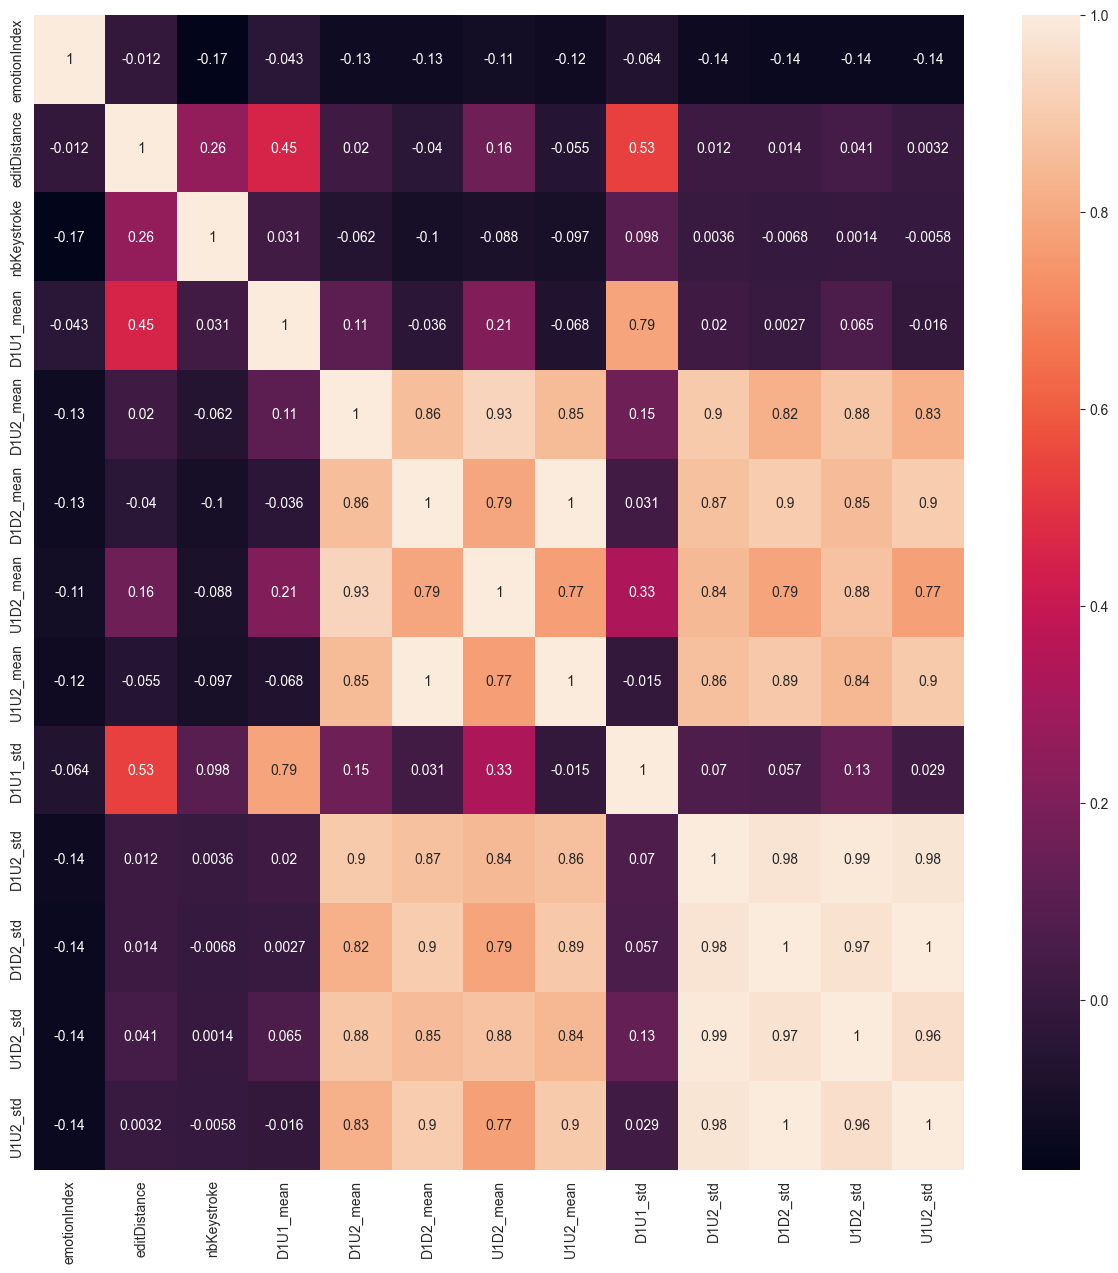

In [8]:
## correlation matrix

# Numeric columns of the dataset
text_free.emotionIndex = text_free.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})
numeric_col = ['emotionIndex', 'editDistance', 'nbKeystroke'] + [col for col in text_free.columns if '_mean' in col] + [
    col for col in text_free.columns if '_std' in col]

# Correlation Matrix formation
corr_matrix = text_free.loc[:, numeric_col].corr()
text_free.emotionIndex = text_free.emotionIndex.map({0: 'N', 1: 'H', 2: 'C', 3: 'S', 4: 'A'})

#Using heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))
sn.heatmap(corr_matrix, annot=True)
plt.plot()

## Join tables: text_free with df_freq_free

In [9]:
# filter free-text experiments in df_freq
df_freq_free = df_freq[df_freq.textIndex == 'FR'].reset_index(drop=True)

In [10]:
# correction of expections to align df_freq_free and text_free tables
text_free.loc[43, 'userId'] = 94
tmp = text_free.loc[29]
text_free.loc[29] = text_free.loc[30]
text_free.loc[30] = tmp

In [11]:
# alignment of df_freq_free and text_free tables
text_free['text_index'] = -1
df_freq_free['text_index'] = -1
index = 0

i = 0
j = 0
while i < len(df_freq_free) and j < len(text_free):
    if df_freq_free.userId[i] == text_free.userId[j] and df_freq_free.emotionIndex[i] == text_free.emotionIndex[j]:
        df_freq_free.loc[i, 'text_index'] = index
        text_free.loc[j, 'text_index'] = index
        index += 1
        i += 1
        j += 1
    elif j != len(text_free) - 1 and df_freq_free.userId[i] == text_free.userId[j + 1] and df_freq_free.emotionIndex[
        i] == text_free.emotionIndex[j + 1]:
        df_freq_free.loc[i, 'text_index'] = index
        text_free.loc[j + 1, 'text_index'] = index
        index += 1
        i += 1
        j += 2
    elif i != len(df_freq_free) - 1 and df_freq_free.userId[i + 1] == text_free.userId[j] and df_freq_free.emotionIndex[
        i + 1] == text_free.emotionIndex[j]:
        df_freq_free.loc[i + 1, 'text_index'] = index
        text_free.loc[j, 'text_index'] = index
        index += 1
        i += 2
        j += 1
    else:
        i += 1
        j += 1

In [12]:
# correction of expections to align df_freq_free and df_user tables
tmp = df_user.loc[10]
df_user.loc[10] = df_user.loc[11]
df_user.loc[11] = tmp
tmp = df_user.loc[70]
df_user.loc[70] = df_user.loc[71]
df_user.loc[71] = tmp
tmp = df_user.loc[91]
df_user.loc[91] = df_user.loc[92]
df_user.loc[92] = tmp

In [13]:
# alignment of df_freq_free and df_user tables
df_freq_free['user_index'] = -1
index = 0

j = 0
for i in range(len(df_freq_free)):
    if i in [20, 38, 58, 68, 129, 139, 150, 154, 173, 225, 227]:
        j += 1
    if j < len(df_user) and df_freq_free.userId[i] == df_user.userId[j]:
        df_freq_free.loc[i, 'user_index'] = j
        i += 1
    else:
        if j < len(df_user) - 1 and df_freq_free.userId[i] == df_user.userId[j + 1]:
            df_freq_free.loc[i, 'user_index'] = j + 1
            i += 1
            j += 1
        else:
            for k in range(1, 7):
                if df_freq_free.userId[i] == df_freq_free.userId[i - k]:
                    df_freq_free.loc[i, 'user_index'] = df_freq_free.loc[i - k, 'user_index']
                    break

In [14]:
# merge all tables
df_free_all = df_freq_free.join(text_free, on='text_index', how='left', rsuffix='_right')
df_free_all = df_free_all.drop(['userId_right', 'emotionIndex_right', 'text_index_right'], axis=1)
df_free_all = df_free_all.join(df_user.reset_index().rename(columns={'index': 'user_index'}), on='user_index',
                               how='left', rsuffix='_right')
df_free_all = df_free_all.drop(['user_index_right', 'userId_right'], axis=1)
df_free_all.head()

,userId,textIndex,emotionIndex,delFreq,leftFreq,TotTime,text_index,user_index,idx_start,idx_end,...,U1U2_mean,U1U2_std,typeWith,typistType,pcTimeAverage,ageRange,gender,status,degree,country
0,100,FR,N,145,0,NaN,0,0,0,147,...,27.120567,155.153800,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
1,100,FR,H,0,0,NaN,1,0,148,204,...,-4.018519,29.255256,2 hands,Touch Typist,More than 3 hours per day,16-19,Female,Student,College/University,Tunisia
2,113,FR,N,44,0,NaN,2,1,205,329,...,288.000000,691.356686,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
3,113,FR,C,24,0,NaN,3,1,330,428,...,341.119565,670.032800,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia
4,113,FR,H,15,0,NaN,4,1,429,483,...,272.692308,231.421904,2 hands,Two Finger Typist,less than an hour per day,20-29,Female,Student,College/University,Tunisia


## Data analysis

### Useful functions

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics, model_selection
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
from tqdm import trange

In [16]:
# Receiving a dictionary of performance metrics and printing them
def show_metrics(performance_metrics):
    for metric_name, metric in performance_metrics.items():
        if metric_name.startswith("Confusion"):
            print("Confusion Matrix: ")
            if len(metric) != 5:
                print(pd.DataFrame(metric))
            else:
                print(pd.DataFrame(metric,
                                   index=list(label_dictionary.values()),
                                   columns=list(label_dictionary.values())))
        else:
            print("Metric : % s, Score : % 5.2f" % (metric_name, metric))

In [17]:
# Plotting the Confusion Matrix as a heatmap
label_dictionary = {1: 'N', 2: 'H', 3: 'C', 4: 'S', 5: 'A'}


def plot_confusion_matrix(confusion_matrix):
    if len(confusion_matrix) != 5:
        df_cm = pd.DataFrame(confusion_matrix)
    else:
        df_cm = pd.DataFrame(confusion_matrix,
                             index=[i for i in label_dictionary.values()],
                             columns=[i for i in label_dictionary.values()])
    plt.figure()
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues")
    plt.show()

In [18]:
# Computing the different Performance Metrics
def compute_metrics(clf, dataX, dataY, show=False):
    # Using Confusion Metrics to compute metrics
    def performance_measures(y_true, y_pred):
        cnf_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        acc = np.mean((TP + TN) / (TP + FP + FN + TN))
        TP_rate = np.mean(TP / (TP + FN))
        FP_rate = np.mean(FP / (FP + TN))
        precision = np.mean(TP / (TP + FP))
        f_measure = 2 * precision * TP_rate / (precision + TP_rate)
        f_micro = metrics.f1_score(y_true, y_pred, average='micro')
        f_macro = metrics.f1_score(y_true, y_pred, average='macro')

        # Returning 
        return (acc, TP_rate, FP_rate, precision, f_measure, f_micro, f_macro,
                np.round(cnf_matrix, 2))

    acc, tp_rate, fp_rate, precision, f_measure, f_micro, f_macro, confusion_matrix = performance_measures(y_true=dataY,
                                                                                                           y_pred=clf.predict(
                                                                                                               dataX))

    performance_metrics = {"ACC": acc, "TP_Rate": tp_rate, "FP_Rate": fp_rate,
                           "Precision": precision, "F_Measure": f_measure, "F_Micro": f_micro, "F_Macro": f_macro,
                           "Confusion Matrix": confusion_matrix}
    if show:
        show_metrics(performance_metrics)

    return performance_metrics

### Data pre-processing

In [19]:
data_free = df_free_all.loc[:, df_free_all.columns.difference(
    ['user_index', 'answer', 'emotionIndex', 'userId', 'textIndex', 'TotTime', 'text_index', 'idx_start', 'idx_end',
     'sentence'])]
label_free = df_free_all.emotionIndex.map({'N': 0, 'H': 1, 'C': 2, 'S': 3, 'A': 4})

In [20]:
# convert categorical features into numerical features
data_free.gender = (data_free.gender == 'Male')
data_free.ageRange = data_free.ageRange.map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
data_free.degree = data_free.degree.map({'High School': 1, 'College/University': 2})
data_free.pcTimeAverage = data_free.pcTimeAverage.map(
    {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
data_free.status = data_free.status.map({'Student': 1, 'Professional': 2})
data_free.typeWith = data_free.typeWith.map({'1 hand': 1, '2 hands': 2})
data_free = pd.get_dummies(data_free, columns=['country', 'typistType'])
data_free = data_free.fillna(-1)

In [21]:
data_free_filter = data_free
#label_free = (label_free == 1)  ## for binary models

### Statistical analysis

In [22]:
data_free.D1U1_mean.describe()

count    235.000000
mean     102.183962
std       44.528857
min        3.489796
25%       84.644915
50%      100.714286
75%      117.112400
max      623.666667
Name: D1U1_mean, dtype: float64

In [23]:
    # in line,'country','typistType'
    
    # only for demographic features
    # 
    # 
    # personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']
    # for col in personal_col:
    #     anova = stats.f_oneway(data_free.loc[data_free.D1U2_mean < 372, col],
    #                            data_free.loc[(data_free.D1U2_mean >= 372) & (data_free.D1U2_mean < 446), col],
    #                            data_free.loc[(data_free.D1U2_mean >= 446) & (data_free.D1U2_mean < 574), col],
    #                            data_free.loc[data_free.D1U2_mean >= 574, col])
    #     print(col + ': ' + str(anova))
#     
#     
# personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']
# for col in personal_col:
#         anova = stats.f_oneway(data_free.loc[data_free.D1D2_mean < 372, col],
#                                data_free.loc[(data_free.D1D2_mean >= 372) & (data_free.D1D2_mean < 446), col],
#                                data_free.loc[(data_free.D1D2_mean >= 446) & (data_free.D1D2_mean < 574), col],
#                                data_free.loc[data_free.D1D2_mean >= 574, col])
#         print(col + ': ' + str(anova))
    
test_columns = ['D1U2_mean', 'D1D2_mean', 'D1D2_mean', 'U1D2_mean']
personal_col = ['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status']

for column in test_columns:
        for col in personal_col:
            anova = stats.f_oneway(data_free.loc[data_free[column] < 372, col],
                                   data_free.loc[(data_free[column] >= 372) & (data_free[column] < 446), col],
                                   data_free.loc[(data_free[column] >= 446) & (data_free[column] < 574), col],
                                   data_free.loc[data_free[column] >= 574, col])
            print(col + ': ' + str(anova))
        

        

typeWith: F_onewayResult(statistic=1.5165383466752125, pvalue=0.21094643995214019)
gender: F_onewayResult(statistic=1.5264998018995204, pvalue=0.20835703916217313)
ageRange: F_onewayResult(statistic=2.2679154334853315, pvalue=0.08138116258879094)
degree: F_onewayResult(statistic=0.335322606831029, pvalue=0.79981181432536)
pcTimeAverage: F_onewayResult(statistic=2.829350253966248, pvalue=0.03923893758331766)
status: F_onewayResult(statistic=4.2294065261630305, pvalue=0.00619267691858431)
typeWith: F_onewayResult(statistic=2.868674187899302, pvalue=0.03727139058277848)
gender: F_onewayResult(statistic=1.642499495998926, pvalue=0.18032269073951496)
ageRange: F_onewayResult(statistic=4.664182022556698, pvalue=0.0034800039989746905)
degree: F_onewayResult(statistic=0.8353605059393695, pvalue=0.4756588477286309)
pcTimeAverage: F_onewayResult(statistic=5.240294074054093, pvalue=0.0016213190067492105)
status: F_onewayResult(statistic=5.114902449810686, pvalue=0.0019144712034167954)
typeWith: F

### Multi-class models

In [24]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Method to read a CSV file and predict the emotion
def predict_emotion(csv_file, model_file):
    # Load the model
    model = load_model(model_file)

    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Preprocess the data (assuming you are using MinMaxScaler in your project)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Predict the emotion
    predictions = model.predict(data)

    return predictions 

In [25]:
#define classification models
classifiers_name = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg',
                       class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False),
    SVC(kernel='rbf', decision_function_shape='ovr', probability=True),  #, class_weight={0:0.1,1:1,2:1,3:1,4:1}),
    MLPClassifier(alpha=1, max_iter=500)]

In [26]:
# micro-F1 scores with a 10-fold cross-validation method

model_scores_micro = {}
for i in range(len(classifiers)):
    model_scores_micro[classifiers_name[i]] = []
    print(classifiers_name[i])
    for j in range(10):
        model = classifiers[i]
        scores = model_selection.cross_val_score(model, X=data_free_filter, y=label_free, cv=10, n_jobs=1,
                                                 scoring='f1_micro')
        model_scores_micro[classifiers_name[i]] += list(scores)
    mean = np.nanmean(model_scores_micro[classifiers_name[i]])
    std = np.nanstd(model_scores_micro[classifiers_name[i]])
    model_scores_micro[classifiers_name[i]] = [mean, std]

model_scores_micro

LogReg


D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib

RF
XGB
SVM
MLP


{'LogReg': [0.17880434782608692, 0.06469725150287983],
 'RF': [0.21378623188405793, 0.05470624266244563],
 'XGB': [0.4601449275362318, 0.06926357458379678],
 'SVM': [0.4724637681159421, 0.013133745623472371],
 'MLP': [0.3197463768115942, 0.1049147679696345]}

In [27]:
# macro-F1 scores with a 10-fold cross-validation method

# model_scores_macro = {}
# for i in range(len(classifiers)):
#    model_scores_macro[classifiers_name[i]] = []
#    print(classifiers_name[i])
#    for j in range(10):
#        model = classifiers[i]
#        scores = model_selection.cross_val_score#(model, X=data_free_filter, y=label_free, cv=10, #n_jobs=1,
                                              
#scoring='f1_macro')
#        model_scores_macro[classifiers_name[i]] += #list(scores)
#    mean = np.nanmean#(model_scores_macro[classifiers_name[i]])
#    std = np.nanstd(model_scores_macro[classifiers_name[i]])
#    model_scores_macro[classifiers_name[i]] = [mean, #std]


#model_scores_macro


from sklearn.model_selection import cross_val_score
from numpy import nanmean, nanstd

# Define the classifiers
classifiers_name = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']
classifiers = [
    LogisticRegression(multi_class='auto', max_iter=500, solver='newton-cg', class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1, 2: 1, 3: 1, 4: 1}),
    xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False),
    SVC(kernel='rbf', decision_function_shape='ovr', probability=True),
    MLPClassifier(alpha=1, max_iter=500)
]

# Initialize a dictionary to hold the macro-F1 scores
model_scores_macro = {}

# For each classifier
for i in range(len(classifiers)):
    # Initialize a list to hold the scores for this classifier
    model_scores_macro[classifiers_name[i]] = []
    
    # Print the name of the classifier
    print(classifiers_name[i])
    
    # Perform 10-fold cross-validation
    for j in range(10):
        # Get the current classifier
        model = classifiers[i]
        
        # Compute the cross-validation scores
        scores = cross_val_score(model, X=data_free_filter, y=label_free, cv=10, n_jobs=1, scoring='f1_macro')
        
        # Add the scores to the list for this classifier
        model_scores_macro[classifiers_name[i]] += list(scores)
    
    # Compute the mean and standard deviation of the scores
    mean = nanmean(model_scores_macro[classifiers_name[i]])
    std = nanstd(model_scores_macro[classifiers_name[i]])
    
    # Store the mean and standard deviation in the dictionary
    model_scores_macro[classifiers_name[i]] = [mean, std]


# Print the macro-F1 scores
model_scores_macro

LogReg


D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib

RF
XGB
SVM
MLP


{'LogReg': [0.16008169608169606, 0.07010793047274466],
 'RF': [0.19384890044595926, 0.06515261407817466],
 'XGB': [0.2928075625523901, 0.08323727323805016],
 'SVM': [0.12832492997198877, 0.0024135452489030917],
 'MLP': [0.17219448108232505, 0.06635434115332821]}

#### Best multi-class model

In [28]:
def iterate_all_models(model_name):
    best_model = model_name
    X_train, X_test, Y_train, Y_test = train_test_split(data_free_filter, label_free, test_size=0.2)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = classifiers[classifiers_name.index(best_model)]
    model.fit(X_train, Y_train)
    
    
    # Check if the model is fitted
    print("Before saving, is the model fitted? ", hasattr(model, 'classes_'))

    # Save the last trained model
    save_model(model, 'model.pkl')

    performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
    plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [29]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Method to read a CSV file and predict the emotion
def predict_emotion(csv_file, model_file):
    # Load the model
    model = load_model(model_file)

    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Preprocess the data
    data['typeWith'] = data['typeWith'].map({'1 hand': 1, '2 hands': 2})
    data['gender'] = (data['gender'] == 'Male')
    data['ageRange'] = data['ageRange'].map({'16-19': 1, '20-29': 2, '30-39': 3, '>=50': 4})
    data['degree'] = data['degree'].map({'High School': 1, 'College/University': 2})
    data['pcTimeAverage'] = data['pcTimeAverage'].map(
        {'less than an hour per day': 1, 'between 1 hour and 3 hours per day': 2, 'More than 3 hours per day': 3})
    data['status'] = data['status'].map({'Student': 1, 'Professional': 2})

    # Convert 'country' and 'typistType' columns if they exist
    if 'country' in data.columns and 'typistType' in data.columns:
        data = pd.get_dummies(data, columns=['country', 'typistType'])

    data = data.fillna(-1)

    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Predict the emotion
    predictions = model.predict(data)

    return predictions

In [30]:
features = data_free.columns.tolist()
print(features)
print(data_free)

['D1D2_mean', 'D1D2_std', 'D1U1_mean', 'D1U1_std', 'D1U2_mean', 'D1U2_std', 'U1D2_mean', 'U1D2_std', 'U1U2_mean', 'U1U2_std', 'ageRange', 'degree', 'delFreq', 'editDistance', 'gender', 'leftFreq', 'nbKeystroke', 'pcTimeAverage', 'status', 'typeWith', 'country_Angola', 'country_Arabie_Saoudite', 'country_Bahamas', 'country_Barbade', 'country_Belgique', 'country_Belize', 'country_Canada', 'country_France', 'country_Germany', 'country_Italy', 'country_Portugal', 'country_Spain', 'country_Suisse', 'country_Tunisia', 'country_United Arab Emirates', 'country_United_States', 'typistType_One Finger Typist', 'typistType_Touch Typist', 'typistType_Two Finger Typist']
      D1D2_mean     D1D2_std   D1U1_mean    D1U1_std   D1U2_mean     D1U2_std  \
0    237.190476  1925.711443  129.055556  209.692492  354.823529   388.461102   
1    169.339286   731.543458  623.666667  805.151884  807.000000   738.000000   
2    316.620968   696.210104   81.840426   17.108106  452.322581   768.536497   
3    389.5

### Binary classification

For model:  LogReg  matrix is:
Before saving, is the model fitted?  True
Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.17
Metric : F_Macro, Score :  0.14
Confusion Matrix: 
     N     H     C     S     A
N  0.0  0.20  0.45  0.30  0.05
H  0.0  0.30  0.30  0.30  0.10
C  0.0  0.20  0.20  0.40  0.20
S  0.0  0.25  0.00  0.50  0.25
A  0.0  0.25  0.00  0.75  0.00


D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\HCI-Six\AppData\Local\Temp\ipykernel_12744\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


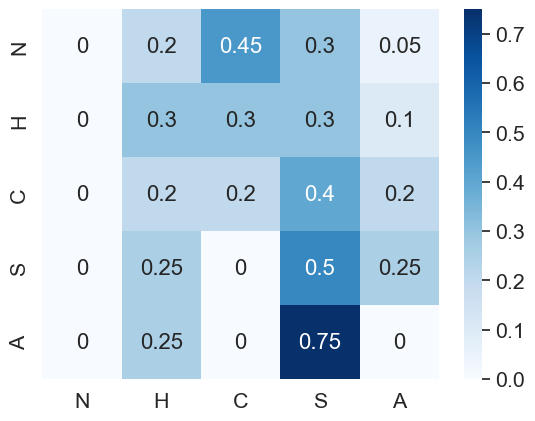

For model:  RF  matrix is:
Before saving, is the model fitted?  True
Metric : ACC, Score :  0.78
Metric : TP_Rate, Score :  0.45
Metric : FP_Rate, Score :  0.14
Metric : Precision, Score :  0.43
Metric : F_Measure, Score :  0.44
Metric : F_Micro, Score :  0.28
Metric : F_Macro, Score :  0.29
Confusion Matrix: 
      N     H     C     S     A
N  0.05  0.27  0.27  0.27  0.14
H  0.09  0.45  0.27  0.09  0.09
C  0.00  0.00  1.00  0.00  0.00
S  0.40  0.00  0.20  0.40  0.00
A  0.00  0.17  0.50  0.00  0.33


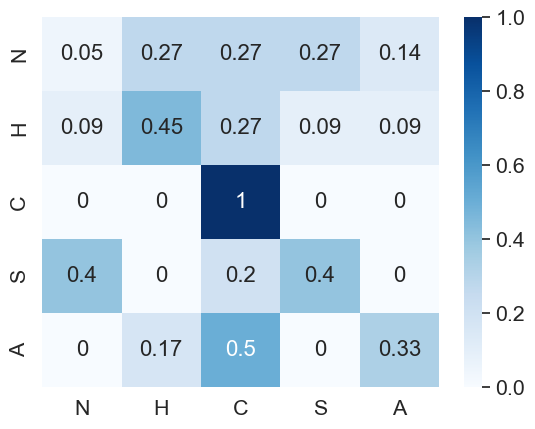

For model:  XGB  matrix is:
Before saving, is the model fitted?  True
Metric : ACC, Score :  0.76
Metric : TP_Rate, Score :  0.40
Metric : FP_Rate, Score :  0.15
Metric : Precision, Score :  0.50
Metric : F_Measure, Score :  0.45
Metric : F_Micro, Score :  0.49
Metric : F_Macro, Score :  0.41
Confusion Matrix: 
      N     H     C     S     A
N  0.62  0.12  0.15  0.08  0.04
H  0.50  0.25  0.00  0.25  0.00
C  0.71  0.14  0.14  0.00  0.00
S  0.20  0.00  0.20  0.60  0.00
A  0.40  0.00  0.20  0.00  0.40


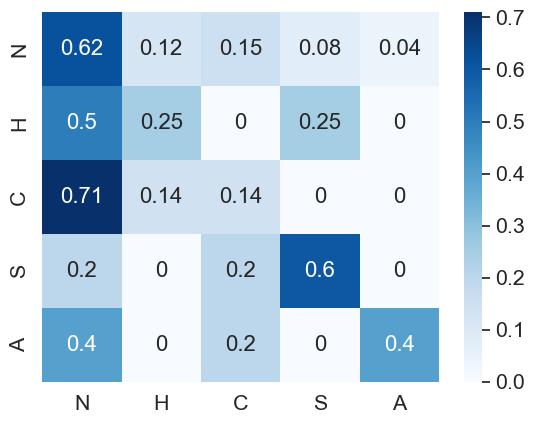

For model:  SVM  matrix is:
Before saving, is the model fitted?  True
Metric : ACC, Score :  0.68
Metric : TP_Rate, Score :  0.20
Metric : FP_Rate, Score :  0.20
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.51
Metric : F_Macro, Score :  0.14
Confusion Matrix: 
     N    H    C    S    A
N  1.0  0.0  0.0  0.0  0.0
H  1.0  0.0  0.0  0.0  0.0
C  1.0  0.0  0.0  0.0  0.0
S  1.0  0.0  0.0  0.0  0.0
A  1.0  0.0  0.0  0.0  0.0


C:\Users\HCI-Six\AppData\Local\Temp\ipykernel_12744\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


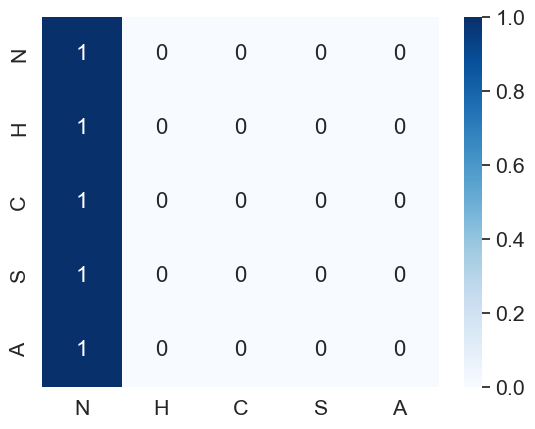

For model:  MLP  matrix is:
Before saving, is the model fitted?  True
Metric : ACC, Score :  0.66
Metric : TP_Rate, Score :  0.14
Metric : FP_Rate, Score :  0.21
Metric : Precision, Score :   nan
Metric : F_Measure, Score :   nan
Metric : F_Micro, Score :  0.32
Metric : F_Macro, Score :  0.10
Confusion Matrix: 
      N     H    C     S     A
N  0.71  0.05  0.0  0.14  0.10
H  0.88  0.00  0.0  0.00  0.12
C  0.86  0.00  0.0  0.14  0.00
S  1.00  0.00  0.0  0.00  0.00
A  1.00  0.00  0.0  0.00  0.00


D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HCI-Six\AppData\Local\Temp\ipykernel_12744\2597144265.py:20: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(TP / (TP + FP))


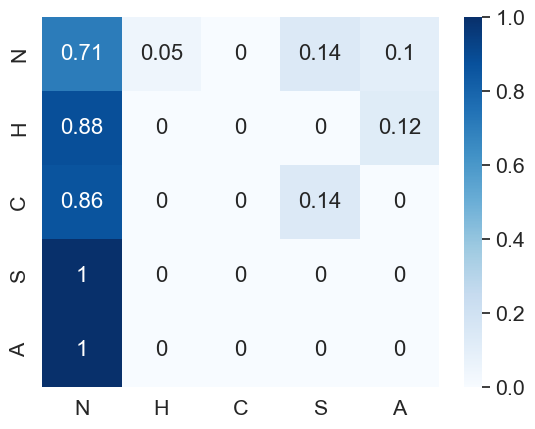

In [31]:
# run all probabilities

model_names = ['LogReg', 'RF', 'XGB', 'SVM', 'MLP']

for model_name in model_names:
    print("For model: ", model_name, " matrix is:")
    iterate_all_models(model_name)

In [32]:
## binary classification with XGBoost
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)

    for i in range(10):
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss', use_label_encoder=False)
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.604 0.111
0.593 0.113
0.591 0.167


Class H:
0.809 0.061
0.463 0.055
0.025 0.075


Class C:
0.851 0.032
0.531 0.092
0.133 0.163


Class S:
0.864 0.041
0.624 0.129
0.292 0.233


Class A:
0.903 0.041
0.619 0.159
0.233 0.238


In [33]:
## binary classification with Random Forest
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)

    for i in range(10):
        model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight={0: 0.1, 1: 1})
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.462 0.031
0.331 0.037
0.946 0.056


Class H:
0.78 0.064
0.442 0.034
0.008 0.043


Class C:
0.759 0.093
0.46 0.078
0.07 0.136


Class S:
0.815 0.09
0.611 0.116
0.431 0.345


Class A:
0.871 0.044
0.572 0.108
0.238 0.231


In [34]:
## binary classification with SVM
for emotion_index in range(5):
    f1_micro = np.array([])
    f1_macro = np.array([])
    recall = np.array([])

    print("Class " + label_dictionary[emotion_index + 1] + ":")
    label_free_binary = (label_free == emotion_index).astype(int)

    for i in range(10):
        model = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)
        scores = model_selection.cross_validate(model, X=data_free_filter, y=label_free_binary, cv=10, n_jobs=1,
                                                scoring=['f1_micro', 'f1_macro', 'recall'])

        f1_micro = np.concatenate([f1_micro, scores['test_f1_micro']])
        f1_macro = np.concatenate([f1_macro, scores['test_f1_macro']])
        recall = np.concatenate([recall, scores['test_recall']])

    print(np.round(np.nanmean(f1_micro), 3), np.round(np.nanstd(f1_micro), 3))
    print(np.round(np.nanmean(f1_macro), 3), np.round(np.nanstd(f1_macro), 3))
    print(np.round(np.nanmean(recall), 3), np.round(np.nanstd(recall), 3))

    print()
    print()

Class N:
0.566 0.081
0.483 0.106
0.203 0.14


Class H:
0.847 0.018
0.459 0.005
0.0 0.0


Class C:
0.864 0.015
0.463 0.005
0.0 0.0


Class S:
0.864 0.015
0.463 0.005
0.0 0.0


Class A:
0.898 0.019
0.473 0.005
0.0 0.0


#### predict model

In [35]:
# note to self: you first have to conduct a cell running the iterateall method, to save model correctly
# Predict the emotion from a CSV file
predictions = predict_emotion('data/free_dummy_data.csv', 'model.pkl')
print(predictions)

[1 1 1]


## Feature importance

In [36]:
scaler = MinMaxScaler()
data_free = pd.DataFrame(scaler.fit_transform(data_free), columns=data_free.columns)

#### Chi-squared

In [37]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#excluding ,'country','typistType

demo_features = np.array(['typeWith', 'gender', 'ageRange', 'degree', 'pcTimeAverage', 'status'])

# Feature extraction
test = SelectKBest(score_func=chi2, k=8)
fit = test.fit(data_free.loc[:, demo_features].fillna(100).replace(-1, 16),
               pd.cut(data_free.D1U2_mean.fillna(0), bins=[0, 372, 445, 573, 4306], labels=[1, 2, 3, 4]).fillna(1))

# Summarize scores
np.set_printoptions(precision=3)
print("Ordered features by importance with their corresponding chi2 score")
print(demo_features[np.argsort(fit.scores_)][::-1])
print(fit.scores_[np.argsort(fit.scores_)][::-1])

Ordered features by importance with their corresponding chi2 score
['status' 'pcTimeAverage' 'degree' 'ageRange' 'gender' 'typeWith']
[nan nan nan nan nan nan]


D:\Student_Projects\LaraK\Coding_Projects\erkd\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=8 is greater than n_features=6. All the features will be returned.
  warnings.warn(


#### Correlation coefficients

In [38]:
importances = data_free.apply(lambda x: x.corr(data_free.D1U2_mean))
indices = np.argsort(importances)
indices_abs = np.argsort(np.abs(importances))[::-1]
print(importances[indices_abs])

D1U2_mean                       1.000000
U1D2_mean                       0.929312
D1U2_std                        0.897616
U1D2_std                        0.883536
D1D2_mean                       0.858418
U1U2_mean                       0.851738
U1U2_std                        0.825045
D1D2_std                        0.822423
country_Tunisia                 0.225452
typistType_Touch Typist        -0.221670
typeWith                       -0.219643
typistType_One Finger Typist    0.186459
ageRange                        0.173974
typistType_Two Finger Typist    0.153602
D1U1_std                        0.153070
pcTimeAverage                  -0.132658
country_France                 -0.126973
D1U1_mean                       0.111385
country_Belize                 -0.106953
country_Angola                 -0.074380
country_Germany                -0.069298
nbKeystroke                    -0.062158
leftFreq                        0.056437
country_Arabie_Saoudite        -0.051568
country_Canada  

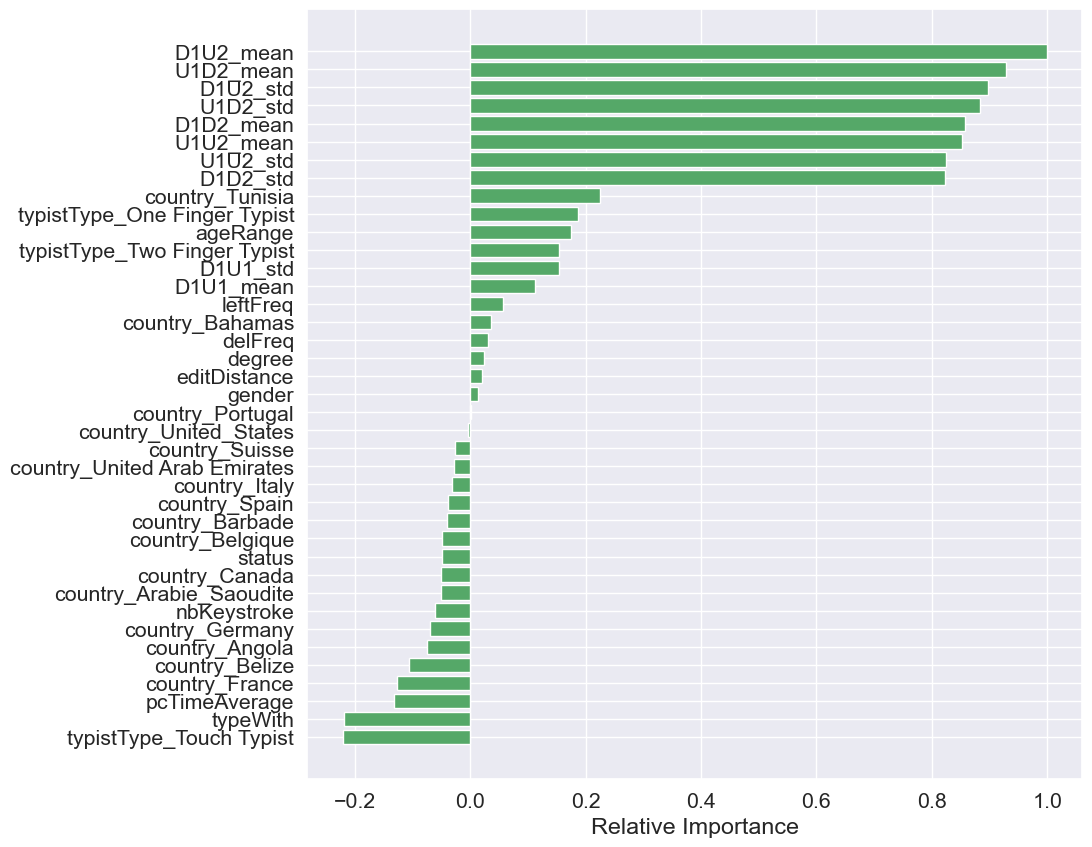

In [39]:
plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), importances[indices].index.values)
plt.xlabel('Relative Importance')
plt.show()

#### Information Gain

In [40]:
from info_gain import info_gain

importances_ig = []
for col in data_free.columns:
    importances_ig.append(info_gain.info_gain(data_free[col], data_free.D1U2_mean))
indices_ig = np.argsort(importances_ig)[::-1]
pd.concat([pd.Series(data_free.columns[indices_ig]), pd.Series(np.sort(importances_ig)[::-1])], axis=1).set_index(0)

,1
0,
D1D2_mean,5.459586
D1D2_std,5.459586
D1U1_mean,5.459586
D1U2_mean,5.459586
U1D2_std,5.453686
D1U1_std,5.453686
D1U2_std,5.453686
U1D2_mean,5.453686
U1U2_std,5.445561


#### Mutual information

<Axes: >

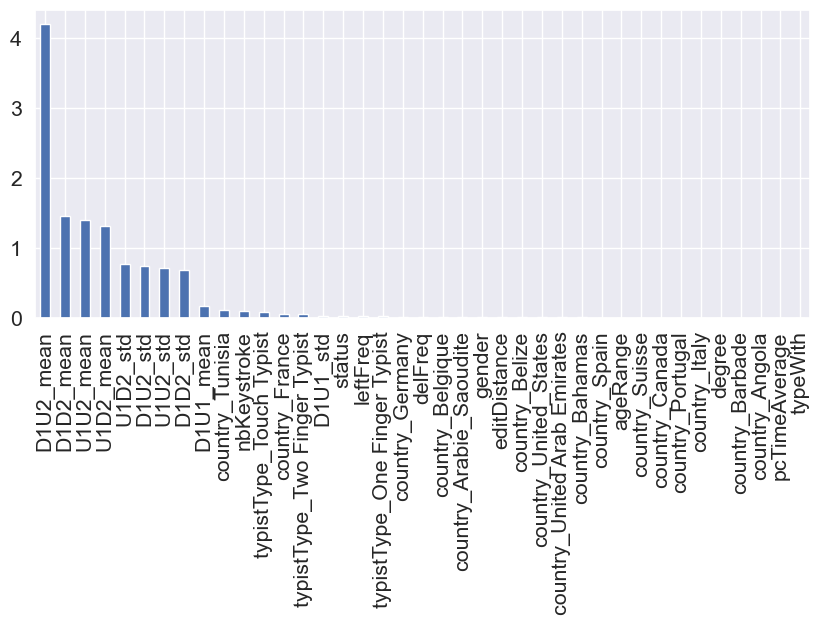

In [41]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(data_free, data_free.D1U2_mean)
mi = pd.Series(mi)
mi.index = data_free.columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))

#### Recursive Feature Elimination (RFE)

In [42]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
rfe = RFE(model, 1)
fit = rfe.fit(data_free, label_free)

print("Feature Ranking: %s" % fit.ranking_)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [ ]:
list(data_free.columns[fit.ranking_ - 1])

#### SHAP values

In [ ]:
# DF, based on which importance is checked
X_importance = pd.DataFrame(data_free_filter, columns=data_free_filter.columns)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance, max_display=data_free.shape[1])

#### RF feature importance

In [ ]:
best_model = 'RF'
X_train, X_test, Y_train, Y_test = train_test_split(data_free, label_free, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_free.columns).nlargest(data_free.shape[1])[::-1].plot(kind='barh')
plt.show()

#### XGB feature importance

In [ ]:
best_model = 'XGB'
X_train, X_test, Y_train, Y_test = train_test_split(data_free, label_free, test_size=0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = classifiers[classifiers_name.index(best_model)]
model.fit(X_train, Y_train)

performance_metrics = compute_metrics(model, X_test, Y_test, show=True)
plot_confusion_matrix(performance_metrics["Confusion Matrix"])

In [ ]:
plt.figure(figsize=(10, 10))
pd.Series(model.feature_importances_, index=data_free.columns).nlargest(data_free.shape[1])[::-1].plot(kind='barh')
plt.show()